# 뉴스 카테고리 다중분류

## 프로젝트 개요
텐서플로 데이터셋 중 하나인 '로이터 뉴스 주제 분류'에 대한 머신러닝 분류 모델을 구축하고 테스트합니다.

## 코드 구성
코드는 크게 세 부분으로 나뉩니다.

- 데이터 전처리 (함수)
로이터 뉴스 데이터에 대해서, 텍스트를 딕셔너리로 바꾸고, 딕셔너리를 다시 디코딩하는 기능을 갖춘 함수입니다.

- 모델 구축 (함수)


- 모델 실행결과 저장 및 시각화

In [1]:
import numpy as np
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 데이터 전처리 함수
def preprocess_data(num_words=None):
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    # 클래스 개수 계산
    num_classes = max(y_train) + 1

    # 단어 인덱스 가져오기
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 인덱스를 단어로 변환하는 딕셔너리 생성 (+3은 특수 토큰 고려)
    index_to_word = { index+3: word for word, index in word_index.items() }
    # 특수 토큰 추가
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index] = token

    # 데이터를 텍스트로 디코딩하는 내부 함수
    def decode_text(encoded_data):
        return [' '.join([index_to_word.get(index, '?') for index in sequence]) for sequence in encoded_data]

    # 훈련 데이터와 테스트 데이터 디코딩
    decoded_x_train = decode_text(x_train)
    decoded_x_test = decode_text(x_test)

    return decoded_x_train, y_train, decoded_x_test, y_test, num_classes

In [12]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# 모델별 설정 함수
def set_model_and_params_naive_bayes():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    params = {
        'clf__alpha': [0.1, 1.0, 10.0],
    }
    return model, params

def set_model_and_params_cnb():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', ComplementNB()),
    ])
    params = {
        'clf__alpha': [0.1, 1.0, 10.0],
    }
    return model, params

# Logistic Regression 설정 함수
def set_model_and_params_logistic_regression():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(max_iter=1000)),  # max_iter 값을 증가
    ])
    params = {
        'clf__C': [0.1, 1.0, 10.0],
        'clf__penalty': ['l2'],
    }
    return model, params

# SVM 설정 함수
def set_model_and_params_svm():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC()),
    ])
    params = {
        'clf__C': [0.1, 1.0, 10.0],
        'clf__kernel': ['linear', 'rbf'],
    }
    return model, params

# Decision Tree 설정 함수
def set_model_and_params_decision_tree():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier()),
    ])
    params = {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
    }
    return model, params

# Random Forest 설정 함수
def set_model_and_params_random_forest():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier()),
    ])
    params = {
        'clf__n_estimators': [10, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
    }
    return model, params

# Gradient Boosting 설정 함수
def set_model_and_params_gradient_boosting():
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', GradientBoostingClassifier(subsample=0.8)),  # subsample 추가
    ])
    params = {
        'clf__n_estimators': [50, 100],  # n_estimators 줄이기
        'clf__learning_rate': [0.1, 0.2],  # learning_rate 조정
        'clf__max_depth': [3, 4],  # max_depth 줄이기
        'clf__n_iter_no_change': [5],  # 조기 중단 설정
        'clf__tol': [1e-3],  # 조기 중단을 위한 허용 오차 설정
    }
    return model, params


In [3]:
import time

# 그리드 서치 실행 및 결과 저장 함수
def run_grid_search(model, params, x_train, y_train, x_test, y_test):
    start_time = time.time()  # 시작 시간 기록
    grid_search = GridSearchCV(model, params, n_jobs=-1, cv=5)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    test_score = best_model.score(x_test, y_test)
    end_time = time.time()  # 종료 시간 기록
    elapsed_time = end_time - start_time  # 경과 시간 계산
    return {
        'best_params': grid_search.best_params_,
        'test_score': test_score,
        'elapsed_time': elapsed_time  # 경과 시간 추가
    }

# 모델별 실행 및 결과 저장하는 함수
def run_model_with_different_num_words(model_func, model_name):
    for num_words in [10000, 5000, None]:  # None은 전체 vocab을 사용한다는 의미입니다.
        print(f"\nTraining {model_name} with num_words={num_words}")
        x_train, y_train, x_test, y_test, num_classes = preprocess_data(num_words)
        model, params = model_func()
        result_key = f"{model_name}_num_words_{num_words if num_words is not None else 'all'}"
        all_results[result_key] = run_grid_search(model, params, x_train, y_train, x_test, y_test)

In [4]:
# 모델별 결과를 저장할 딕셔너리
all_results = {}

# 모델별로 함수를 실행합니다.
run_model_with_different_num_words(set_model_and_params_naive_bayes, 'naive_bayes')


Training naive_bayes with num_words=10000

Training naive_bayes with num_words=5000

Training naive_bayes with num_words=None

Training cnb with num_words=10000

Training cnb with num_words=5000

Training cnb with num_words=None

Training logistic_regression with num_words=10000

Training logistic_regression with num_words=5000

Training logistic_regression with num_words=None

Training svm with num_words=10000

Training svm with num_words=5000

Training svm with num_words=None

Training decision_tree with num_words=10000

Training decision_tree with num_words=5000

Training decision_tree with num_words=None

Training random_forest with num_words=10000


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Training random_forest with num_words=5000

Training random_forest with num_words=None


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Training gradient_boosting with num_words=10000


KeyboardInterrupt: 

In [ ]:
run_model_with_different_num_words(set_model_and_params_cnb, 'cnb')

In [ ]:
run_model_with_different_num_words(set_model_and_params_logistic_regression, 'logistic_regression')

In [ ]:
run_model_with_different_num_words(set_model_and_params_svm, 'svm')

In [ ]:
run_model_with_different_num_words(set_model_and_params_decision_tree, 'decision_tree')

In [ ]:
run_model_with_different_num_words(set_model_and_params_random_forest, 'random_forest')

In [13]:
run_model_with_different_num_words(set_model_and_params_gradient_boosting, 'gradient_boosting')


Training gradient_boosting with num_words=10000

Training gradient_boosting with num_words=5000

Training gradient_boosting with num_words=None


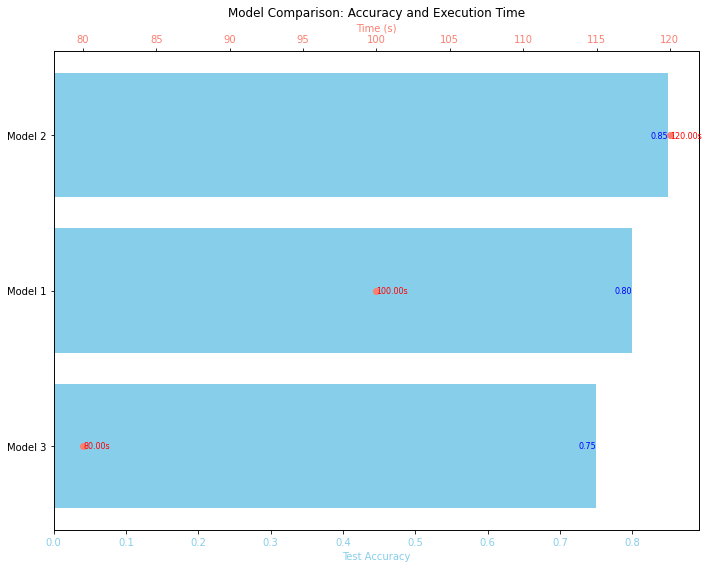

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 결과 시각화 함수 (수정)
def plot_results(results):
    # 결과를 정렬하여 표시합니다.
    sorted_labels = sorted(results.keys(), key=lambda x: (results[x]['test_score'], results[x]['elapsed_time']), reverse=True)
    
    # Test Accuracy와 실행 시간을 분리하여 리스트로 만듭니다.
    labels = []
    test_scores = []
    times = []
    for label in sorted_labels:
        labels.append(label.replace('_', ' ').title())  # 레이블을 보기 좋게 처리합니다.
        test_scores.append(results[label]['test_score'])
        times.append(results[label]['elapsed_time'])

    # 그래프 사이즈를 조정합니다.
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Test Accuracy 막대 그래프를 그립니다.
    y_positions = np.arange(len(labels))
    bars = ax1.barh(y_positions, test_scores, color='skyblue', label='Test Accuracy')
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(labels)
    ax1.invert_yaxis()  # 레이블을 높은 정확도가 위로 오도록 뒤집습니다.
    ax1.set_xlabel('Test Accuracy', color='skyblue')
    ax1.tick_params(axis='x', labelcolor='skyblue')

    # 막대 그래프에 정확도 값을 표시합니다.
    for bar, score in zip(bars, test_scores):
        ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
                 '{0:.2f}'.format(score), 
                 va='center', ha='right', color='blue', fontsize=8)

    # 실행 시간 라인 그래프를 그립니다.
    ax2 = ax1.twiny()  # x 축을 공유하는 새 축을 생성합니다.
    points = ax2.plot(times, y_positions, 'o', color='salmon', label='Time (s)')
    ax2.set_xlabel('Time (s)', color='salmon')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # 라인 그래프에 실행 시간 값을 표시합니다.
    for time, pos in zip(times, y_positions):
        ax2.text(time, pos, '{0:.2f}s'.format(time), 
                 va='center', ha='left', color='red', fontsize=8)

    plt.title('Model Comparison: Accuracy and Execution Time')
    fig.tight_layout()  # 그래프 레이아웃을 조정합니다.
    plt.show()

# 예시 데이터로 함수를 실행해보겠습니다.
results = {
    'model_1': {'test_score': 0.80, 'elapsed_time': 100},
    'model_2': {'test_score': 0.85, 'elapsed_time': 120},
    'model_3': {'test_score': 0.75, 'elapsed_time': 80},
}
plot_results(results)


In [7]:
all_results

{'naive_bayes_num_words_10000': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7506678539626002,
  'elapsed_time': 8.268959999084473},
 'naive_bayes_num_words_5000': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7671415850400712,
  'elapsed_time': 7.058648347854614},
 'naive_bayes_num_words_all': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.709706144256456,
  'elapsed_time': 8.310611248016357},
 'cnb_num_words_10000': {'best_params': {'clf__alpha': 1.0},
  'test_score': 0.7707034728406055,
  'elapsed_time': 7.547343969345093},
 'cnb_num_words_5000': {'best_params': {'clf__alpha': 1.0},
  'test_score': 0.7707034728406055,
  'elapsed_time': 7.440619230270386},
 'cnb_num_words_all': {'best_params': {'clf__alpha': 0.1},
  'test_score': 0.7751558325912734,
  'elapsed_time': 8.254445314407349},
 'logistic_regression_num_words_10000': {'best_params': {'clf__C': 10.0,
   'clf__penalty': 'l2'},
  'test_score': 0.8178984861976848,
  'elapsed_time': 177.8671009540558},


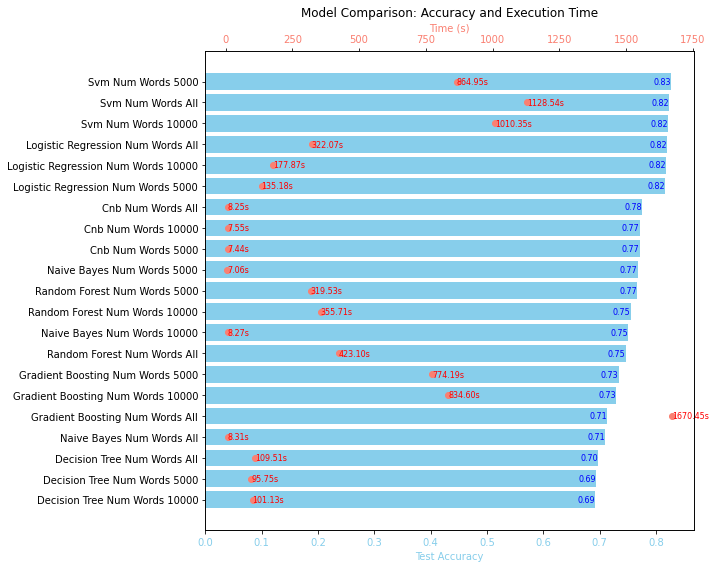

In [18]:
# 모든 모델 실행 결과 시각화
plot_results(all_results)